In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
import xml.etree.ElementTree as ET
import albumentations as A
import shutil
import os
import sys
import traceback


In [2]:
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
train_imgs = "C:/Prajesh/personal/ML_learning/my_work/yolo/dataset/VOC2012/JPEGImages/"
train_maps = "C:/Prajesh/personal/ML_learning/my_work/yolo/dataset/VOC2012/Annotations/"

val_imgs = "C:/Prajesh/personal/ML_learning/my_work/yolo/dataset/VOC2012/ValJPEGImages/"
val_maps = "C:/Prajesh/personal/ML_learning/my_work/yolo/dataset/VOC2012/ValAnnotations/"

classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
           'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

B = 2
N_CLASSES = len(classes)
OBJ_IND = N_CLASSES+5*B
H,W = 224,224
SPLIT_SIZE = H//32
N_EPOCHS = 10
LR = 5e-4
BATCH_SIZE = 32

In [4]:
def process_annotations_xml(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    size_tree = root.find('size')
    height = float(size_tree.find('height').text)
#     print(height)
    width = float(size_tree.find('width').text)
#     print(width)
    depth = float(size_tree.find('depth').text)
#     print(depth)
    bounding_boxes = []
    for obj_tree in root.findall('object'):
        for bb in obj_tree.iter('bndbox'):
            xmin = float(bb.find('xmin').text)
            ymin = float(bb.find('ymin').text)
            xmax = float(bb.find('xmax').text)
            ymax = float(bb.find('ymax').text)
            
#             print(xmin, ymin, xmax, ymax)
            center = [(xmax - xmin), (ymax - ymin)]
            break
        obj_class_name = obj_tree.find('name').text
        class_dict = {classes[i]:i for i in range(len(classes))}
#         print(class_dict[obj_class_name])
        bounding_box = [
            (xmin+xmax)/(2*width),            # normalized center x
            (ymin+ymax)/(2*height),           # normalized center y
            (xmax-xmin)/width,                # normalized width
            (ymax-ymin)/height,               # normalized height
            class_dict[obj_class_name]
        ]
        bounding_boxes.append(bounding_box)
    
    return tf.convert_to_tensor(bounding_boxes)

In [5]:
bbs = process_annotations_xml(train_maps + "2007_000830.xml")
print(bbs)
# for i in bbs:
#     print(i[4])

tf.Tensor(
[[ 0.476       0.736       0.456       0.50133336 10.        ]
 [ 0.409       0.79466665  0.218       0.41066667  8.        ]
 [ 0.6         0.73066664  0.192       0.38933334  8.        ]
 [ 0.568       0.564       0.136       0.19466667  8.        ]], shape=(4, 5), dtype=float32)


In [6]:
def generate_output(bounding_boxes):
    #     output_label = tf.Variable(
#         lambda: tf.zeros([SPLIT_SIZE, SPLIT_SIZE, N_CLASSES+5], dtype = tf.float32)
#     )
    output_label = np.zeros((SPLIT_SIZE, SPLIT_SIZE, N_CLASSES+5))
    bounding_boxes = np.array(bounding_boxes)
    for b in range(len(bounding_boxes)):
        grid_x = bounding_boxes[...,b,0]*SPLIT_SIZE
        grid_y = bounding_boxes[...,b,1]*SPLIT_SIZE
        i = int(grid_x)                          # getting the grid cell with the center in it
        j = int(grid_y)                          # getting the grid cell with the center in it

        output_label[i, j, 0:5] = [
            1.0,
            grid_x%1,
            grid_y%1,
            bounding_boxes[...,b,2],
            bounding_boxes[...,b,3]
        ]
        output_label[i, j, 5+int(bounding_boxes[...,b,4])] = (1.0)
    return tf.convert_to_tensor(output_label, tf.float32)

In [7]:
generate_output(bbs,)[2][5]

<tf.Tensor: shape=(25,), dtype=float32, numpy=
array([1.        , 0.86300004, 0.56266654, 0.218     , 0.41066667,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)>

In [8]:
val_list=['2007_000027.jpg','2007_000032.jpg','2007_000033.jpg','2007_000039.jpg','2007_000042.jpg','2007_000061.jpg',
          '2007_000063.jpg','2007_000068.jpg','2007_000121.jpg','2007_000123.jpg','2007_000129.jpg','2007_000170.jpg',
          '2007_000175.jpg','2007_000187.jpg','2007_000241.jpg','2007_000243.jpg','2007_000250.jpg','2007_000256.jpg',
          '2007_000272.jpg','2007_000323.jpg','2007_000332.jpg','2007_000333.jpg','2007_000346.jpg','2007_000363.jpg',
          '2007_000364.jpg','2007_000392.jpg','2007_000423.jpg','2007_000452.jpg','2007_000464.jpg','2007_000480.jpg',
          '2007_000491.jpg','2007_000504.jpg','2007_000515.jpg','2007_000528.jpg','2007_000529.jpg','2007_000549.jpg',
          '2007_000559.jpg','2007_000572.jpg','2007_000584.jpg','2007_000629.jpg','2007_000636.jpg','2007_000645.jpg',
          '2007_000648.jpg','2007_000661.jpg','2007_000663.jpg','2007_000664.jpg','2007_000676.jpg','2007_000713.jpg',
          '2007_000720.jpg','2007_000727.jpg','2007_000733.jpg','2007_000738.jpg','2007_000762.jpg','2007_000768.jpg',
          '2007_000783.jpg','2007_000793.jpg','2007_000799.jpg','2007_000804.jpg','2007_000807.jpg','2007_000822.jpg',
          '2007_001299.jpg','2007_001311.jpg','2007_001321.jpg','2007_001340.jpg']

In [9]:
# for name in val_list:
#     shutil.move(train_maps+name[:-3]+"xml", val_maps+name[:-3]+"xml")
    
# for name in val_list:
#     shutil.move(train_imgs+name, val_imgs+name)

In [10]:
train_img_paths = []
train_annot_paths = []

val_img_paths = []
val_annot_paths = []

for i in os.listdir(train_maps):
    train_img_paths.append(train_imgs+i[:-3]+'jpg')
    train_annot_paths.append(train_maps+i)
    
for i in os.listdir(val_maps):
    val_img_paths.append(val_imgs+i[:-3]+'jpg')
    val_annot_paths.append(val_maps+i)
    
print(len(train_img_paths), len(train_annot_paths))
print(len(val_img_paths), len(val_annot_paths))

17061 17061
64 64


In [11]:
train_data = tf.data.Dataset.from_tensor_slices((train_img_paths, train_annot_paths))
val_data = tf.data.Dataset.from_tensor_slices((val_img_paths, val_annot_paths))

In [12]:
for i in val_data.take(1):
    print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'C:/Prajesh/personal/ML_learning/my_work/yolo/dataset/VOC2012/ValJPEGImages/2007_000027.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C:/Prajesh/personal/ML_learning/my_work/yolo/dataset/VOC2012/ValAnnotations/2007_000027.xml'>)


In [13]:
def get_imbboxes(im_path, xml_path):
    img = tf.io.decode_jpeg(tf.io.read_file(im_path))
    # img = tf.cast(img, dtype = tf.float32)
    img = tf.cast(tf.image.resize(img, size = [H, W]), dtype = tf.float32)
    
    bboxes = tf.numpy_function(func = process_annotations_xml, inp=[xml_path], Tout=tf.float32)
    
    return img, bboxes

In [14]:
train_dataset = train_data.map(get_imbboxes)
val_dataset = val_data.map(get_imbboxes)

In [15]:
for i, j in train_dataset.take(1):
    # plt.imshow(np.array(i))
    print(i.shape, j)
    break

(224, 224, 3) tf.Tensor(
[[ 0.476       0.736       0.456       0.50133336 10.        ]
 [ 0.409       0.79466665  0.218       0.41066667  8.        ]
 [ 0.6         0.73066664  0.192       0.38933334  8.        ]
 [ 0.568       0.564       0.136       0.19466667  8.        ]], shape=(4, 5), dtype=float32)


In [16]:
cv2.imwrite("train_dataset_test_img.jpg", np.array(i))

True

In [17]:
transforms = A.Compose([
    A.Resize(H, W),
    A.RandomCrop(
        width = np.random.randint(int(0.9*W), W),
        height = np.random.randint(int(0.9*H), H),
        p = 0.5
    ),
    A.RandomScale(scale_limit = 0.1, interpolation = cv2.INTER_LANCZOS4, p = 0.5),
    A.HorizontalFlip(p = 0.5),
    A.Resize(H, W),
], bbox_params= A.BboxParams(format='yolo', min_area=25, min_visibility=0.1))

In [18]:
def aug_albument(img, bbox):
    augment = transforms(image = img, bboxes = bbox)
    
    return [tf.convert_to_tensor(augment["image"], dtype = tf.float32), tf.convert_to_tensor(augment["bboxes"], dtype = tf.float32)]

In [19]:
def process_aug_data(img, bbox):
    aug = tf.numpy_function(func = aug_albument, inp = [img, bbox], Tout = (tf.float32, tf.float32))
    return aug[0], aug[1]

In [20]:
def process_tf_augment(img, y):
    img = tf.image.random_brightness(img, max_delta = 50.0)
    img = tf.image.random_saturation(img, lower = 0.5, upper = 1.5)
    img = tf.image.random_contrast(img, lower = 0.5, upper = 1.5)
    img = tf.clip_by_value(img, 0, 255)
    labels = tf.numpy_function(func = generate_output, inp = [y], Tout = (tf.float32))
    
    return img, labels

In [21]:
def preprocess(img, bboxes):
    labels = tf.numpy_function(func = generate_output, inp = [bboxes], Tout = tf.float32)
    return img, labels

In [22]:
train_data2 = train_dataset.map(process_aug_data)

In [30]:
train_Data = train_data2.map(process_tf_augment)
val_Data = val_dataset.map(preprocess)

In [33]:
for x, y in train_Data.take(1):
    print(y.shape)

(7, 7, 25)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

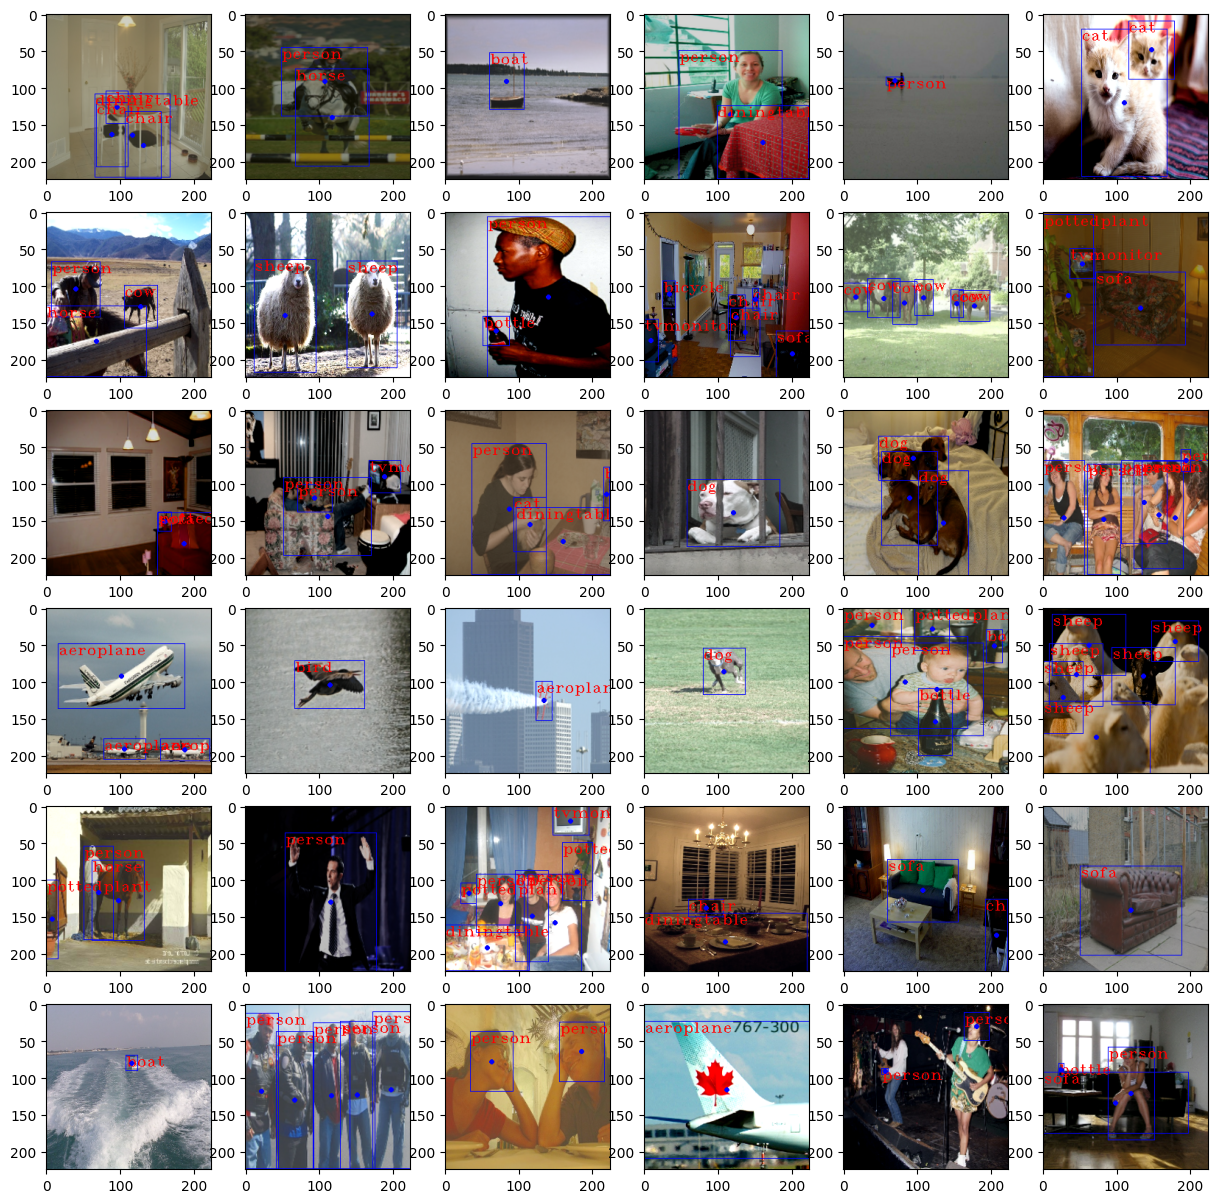

In [35]:
import csv
import matplotlib.patches as patches
plt.figure(figsize=(15, 15))

count = 1
for x, y in train_Data.take(36):
    # print(y.shape)
    if count <= 36:
        image_with_circle = np.array(x).copy()/255.0
        for i in range(SPLIT_SIZE):
            for j in range(SPLIT_SIZE):
                if y[i, j, 0] > 0.0:
                    # print(i, j)
                    # print(y[i, j])
                    for c in range(25):
                        if y[i,j,c] == 1.0:
                            class_ind = c
                    # print(class_ind)
                    label = y[i, j]
                    label = label.numpy()
                    nxc = (label[1]+i)*32
                    nyc = (label[2]+j)*32
                    lxmin = nxc - (label[3]/2)*H
                    lymin = nyc - (label[4]/2)*W
                    lxmax = nxc + (label[3]/2)*H
                    lymax = nyc + (label[4]/2)*W
                    # print("--------------------------")
                    # print(count)
                    # print(i, j)
                    # print(np.array((label[0], label[1], label[2], label[3], label[4])))
                    # print(nxc, nyc, lxmin, lymin, lxmax, lymax)
                    # print("--------------------------")
                    # image_with_circle = np.array(x).copy()/255
                    # x = cv2.resize(np.array(x), (H, W))
                    cv2.rectangle(
                        image_with_circle,
                        (int(lxmin), int(lymin)),
                        (int(lxmax), int(lymax)),
                        (0,0,5*count),
                        1
                    )
                    cv2.putText(
                        image_with_circle,
                        classes[class_ind-5],
                        (int(lxmin), int(lymin)+15),
                        cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        1,
                        (255, 0, 0),
                        1
                    )
                    circle_color = (0, 0, 255)  # BGR color (red in this example)
                    circle_thickness = 2
                    cv2.circle(image_with_circle, (int(nxc), int(nyc)), 2, circle_color, circle_thickness)

            plt.subplot(6,6,count)
            plt.imshow(image_with_circle)
        count += 1
    else:
        break

In [36]:
train_Data = (
    train_Data
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [37]:
val_Data = (
    val_Data
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
# for i, j in train_Data.take(1):
#     print(i.shape, j)

In [38]:
NUM_FILTERS = 512
OUTPUT_DIM = N_CLASSES+5*B

In [39]:
# base_model = tf.keras.applications.resnet50.ResNet50(
base_model = tf.keras.applications.efficientnet.EfficientNetB1(
    weights = 'imagenet',
    input_shape = (H, W, 3),
    include_top = False,
)

base_model.trainable = False
# base_model.save('efficientNetB1')
base_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

In [40]:
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Dropout, Reshape, Flatten

In [41]:
yolo_basic = tf.keras.Sequential([
    base_model,
    
    Conv2D(NUM_FILTERS, (3,3), padding = 'same', kernel_initializer = 'he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha = 0.1),
    
    Conv2D(NUM_FILTERS, (3,3), padding = 'same', kernel_initializer = 'he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha = 0.1),
    
    Conv2D(NUM_FILTERS, (3,3), padding = 'same', kernel_initializer = 'he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha = 0.1),
    
    Conv2D(NUM_FILTERS, (3,3), padding = 'same', kernel_initializer = 'he_normal'),
    LeakyReLU(alpha = 0.1),
    
    # GlobalAveragePooling2D(),
    Flatten(),
    
    Dense(NUM_FILTERS, kernel_initializer = 'he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha = 0.1),
    
    Dropout(rate = 0.5),
    
    Dense(SPLIT_SIZE*SPLIT_SIZE*OUTPUT_DIM, activation = 'sigmoid'),
    
    Reshape((SPLIT_SIZE, SPLIT_SIZE, OUTPUT_DIM)),
])

yolo_basic.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 512)         5898752   
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                        

In [42]:
checkpoint_filepath = "C:/Prajesh/personal/ML_learning/my_work/yolo/saved_models/yolo_resnet50.h5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_loss',
    save_weights_only=True,
    mode = 'min',
    save_best_only=True
)

In [43]:
def scheduler(epoch, lr):
    if epoch < 40:
        return 1e-3
    elif epoch >= 40 and epoch < 80:
        return 5e-4
    else:
        return 1e-4
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [44]:
def compute_iou(boxes1, boxes2):
    boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,
                         boxes1[..., 1] - boxes1[..., 3] / 2.0,
                         boxes1[..., 0] + boxes1[..., 2] / 2.0,
                         boxes1[..., 1] + boxes1[..., 3] / 2.0],
                        axis=-1)

    boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                         boxes2[..., 1] - boxes2[..., 3] / 2.0,
                         boxes2[..., 0] + boxes2[..., 2] / 2.0,
                         boxes2[..., 1] + boxes2[..., 3] / 2.0],
                        axis=-1)
    lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2])
    rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:])

    intersection = tf.maximum(0.0, rd - lu)
    inter_square = intersection[..., 0] * intersection[..., 1]

    square1 = boxes1[..., 2] * boxes1[..., 3]
    square2 = boxes2[..., 2] * boxes2[..., 3]

    union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)
    return tf.clip_by_value(inter_square / union_square, 0.0, 1.0)

In [45]:
def difference(x,y):
  return tf.reduce_sum(tf.square(y-x))

In [46]:
def yolo_loss(y_true, y_pred):
    target = y_true[...,0]

    ###################### OBject Loss
    y_pred_extract = tf.gather_nd(y_pred, tf.where(target[:]==1))
    y_target_extract = tf.gather_nd(y_true, tf.where(target[:]==1))

    rescaler = tf.where(target[:]==1)*SPLIT_SIZE
#     rescaler_shape = tf.shape(rescaler)
    upscaler_1 = tf.concat([rescaler[:,1:],tf.zeros([tf.shape(rescaler)[0],2], dtype=tf.int64)],axis=-1)

    target_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
            repeats=[tf.shape(rescaler)[0]], axis=0)*tf.cast(y_target_extract[...,1:5], dtype = tf.float32)
    pred_1_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
            repeats=[tf.shape(rescaler)[0]], axis=0)*tf.cast(y_pred_extract[...,1:5], dtype = tf.float32)
    pred_2_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
            repeats=[tf.shape(rescaler)[0]], axis=0)*tf.cast(y_pred_extract[...,6:10], dtype = tf.float32)

    target_orig = tf.cast(upscaler_1, dtype = tf.float32)+target_upscaler_2
    pred_1_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_1_upscaler_2
    pred_2_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_2_upscaler_2

    mask =tf.cast(tf.math.greater(compute_iou(target_orig,pred_2_orig),
                                compute_iou(target_orig,pred_1_orig)),dtype=tf.int32)

    y_pred_joined=tf.transpose(tf.concat([tf.expand_dims(y_pred_extract[...,0],axis=0),
            tf.expand_dims(y_pred_extract[...,5],axis=0)],axis=0))

    obj_pred = tf.gather_nd(y_pred_joined,tf.stack([tf.range(tf.shape(rescaler)[0]),mask],axis=-1))

    object_loss = difference(tf.cast(obj_pred,dtype =tf.float32)
                ,tf.cast(tf.ones([tf.shape(rescaler)[0]]),dtype=tf.float32))

    ####################### For No object
    y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==0))
    y_target_extract = tf.zeros(tf.shape(y_pred_extract)[0])

    no_object_loss_1 = difference(tf.cast(y_pred_extract[...,0],dtype =tf.float32)
                ,tf.cast(y_target_extract,dtype=tf.float32))

    no_object_loss_2 = difference(tf.cast(y_pred_extract[...,5],dtype =tf.float32)
                ,tf.cast(y_target_extract,dtype=tf.float32))

    no_object_loss = no_object_loss_1+no_object_loss_2

    ######################## For OBject class loss
    y_pred_extract = tf.gather_nd(y_pred[...,10:],tf.where(target[:]==1))
    class_extract = tf.gather_nd(y_true[...,5:],tf.where(target[:]==1))

    class_loss = difference(tf.cast(y_pred_extract,dtype =tf.float32)
                    ,tf.cast(class_extract,dtype=tf.float32))

    ######################### For object bounding box loss
    y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==1))
    centre_joined=tf.stack([y_pred_extract[...,1:3],y_pred_extract[...,6:8]],axis=1)
    centre_pred = tf.gather_nd(centre_joined,tf.stack([tf.range(tf.shape(rescaler)[0]),mask],axis=-1))
    centre_target = tf.gather_nd(y_true[...,1:3], tf.where(target[:]==1))

    centre_loss = difference(centre_pred,centre_target)

    size_joined=tf.stack([y_pred_extract[...,3:5],y_pred_extract[...,8:10]],axis=1)

    size_pred = tf.gather_nd(size_joined,tf.stack([tf.range(tf.shape(rescaler)[0]),mask],axis=-1))
    size_target = tf.gather_nd(y_true[...,3:5], tf.where(target[:]==1))

    size_loss = difference(tf.math.sqrt(tf.math.abs(size_pred)),tf.math.sqrt(tf.math.abs(size_target)))
    box_loss = centre_loss+size_loss

    lambda_coord = 5.0
    lambda_no_obj = 0.5

    loss = object_loss + (lambda_no_obj*no_object_loss)+ tf.cast(lambda_coord*box_loss,dtype=tf.float32)+ tf.cast(class_loss,dtype=tf.float32) 
    return loss

In [47]:
yolo_basic.compile(
    optimizer = tf.keras.optimizers.Adam(1e-3),
    loss = yolo_loss,
)

In [48]:
history = yolo_basic.fit(
    train_Data, 
    validation_data = val_Data,
    epochs = 135,
    verbose = 1,
    callbacks = [lr_callback, cp_callback]
)

Epoch 1/135
534/534 [==============================] - 263s 451ms/step - loss: 191.0924 - val_loss: 239.4528 - lr: 0.0010
Epoch 2/135
534/534 [==============================] - 210s 392ms/step - loss: 156.6796 - val_loss: 210.8956 - lr: 0.0010
Epoch 3/135
534/534 [==============================] - 246s 460ms/step - loss: 146.6637 - val_loss: 199.0257 - lr: 0.0010
Epoch 4/135
534/534 [==============================] - 253s 473ms/step - loss: 139.5641 - val_loss: 196.9688 - lr: 0.0010
Epoch 5/135
534/534 [==============================] - 253s 473ms/step - loss: 133.3106 - val_loss: 191.6615 - lr: 0.0010
Epoch 6/135
 61/534 [==>...........................] - ETA: 3:33 - loss: 163.8499

KeyboardInterrupt: 

In [ ]:
yolo_basic.load_weights("C:/Prajesh/personal/ML_learning/my_work/yolo/saved_models/my_yolo/weights/yolo_resnet50.h5")

In [49]:
COCO_PATH = "C:/Prajesh/personal/ML_learning/my_work/yolo/dataset/coco/val2017/"

In [59]:
def model_test(filename):
    try:
        test_path = COCO_PATH+filename
        
        print(test_path)
        
        img = cv2.resize(cv2.imread(test_path), (H, W))
        
        image = tf.io.decode_jpeg(tf.io.read_file(test_path))
        image = tf.image.resize(image, [H, W])
        
        output = yolo_basic.predict(np.expand_dims(image, axis = 0))
        
        THRESH = 0.5
        
        object_positions = tf.concat(
            [tf.where(output[...,0]>=THRESH),tf.where(output[...,5]>=THRESH)],
            axis = 0
        )
        
        print(object_positions)
        selected_output = tf.gather_nd(output, object_positions)
        final_boxes = []
        final_scores = []
        
        for i, pos in enumerate(object_positions):
            for j in range(2):
                if selected_output[i][j*5]>THRESH:
                    output_box = tf.cast(output[pos[0]][pos[1]][pos[2]][(j*5)+1:(j*5)+5], dtype = tf.float32)
                    
                    x_center = (tf.cast(pos[1], dtype = tf.float32) + output_box[0])*32
                    y_center = (tf.cast(pos[2], dtype = tf.float32) + output_box[1])*32
                    
                    x_width, y_height = tf.math.abs(H * output_box[2]), tf.math.abs(W * output_box[3])
                    
                    x_min, y_min = int(x_center - (x_width/2)), int(y_center - (y_height/2))
                    x_max, y_max = int(x_center + (x_width/2)), int(y_center + (y_height/2))
                    
                    if(x_min <= 0): x_min = 0
                    if(y_min <= 0): y_min = 0
                    if(x_max >= W): x_max = W
                    if(y_max >= H): y_max = H
                    
                    final_boxes.append([
                        x_min, y_min, x_max, y_max,
                        str(classes[tf.argmax(selected_output[...,10:], axis = 1)[i]])
                    ])
                    
                    final_scores.append(selected_output[i][j*5])
        print(final_scores)
        print("finalboxes:", final_boxes)
        
        final_boxes = np.array(final_boxes)
        
        object_classes = final_boxes[...,4]
        nms_boxes = final_boxes[...,0:4]
        
        nms_output = tf.image.non_max_suppression(
            nms_boxes,
            final_scores,
            max_output_size = 100,
            iou_threshold = 0.2,
            score_threshold = float('-inf')
        )
        print(nms_output)
        
        for i in nms_output:
            cv2.rectangle(
                img,
                (int(final_boxes[i][0]), int(final_boxes[i][1])),
                (int(final_boxes[i][2]), int(final_boxes[i][3])),
                (0,0,255),
                1
            )
            cv2.putText(
                img,
                final_boxes[i][-1],
                (int(final_boxes[i][0]), int(final_boxes[i][1])+15),
                cv2.FONT_HERSHEY_COMPLEX_SMALL,
                1,
                (2, 225, 155),
                1
            )
        # cv2.imshow("test", img)
        # cv2.imwrite('C:/Prajesh/personal/ML_learning/my_work/yolo/outputs/' + filename[:-4] + '_det' + '.jpg', cv2.resize(img, (384, 384)))
    except Exception as e:
        traceback.print_exc(file=sys.stdout)
        print("No Object Found !!!")
    return img

C:/Prajesh/personal/ML_learning/my_work/yolo/dataset/coco/val2017/000000000139.jpg
1/1 [==============================] - 0s 42ms/step
tf.Tensor([[0 4 4]], shape=(1, 3), dtype=int64)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.5151883>]
finalboxes: [[128, 123, 154, 153, 'chair']]
tf.Tensor([0], shape=(1,), dtype=int32)
C:/Prajesh/personal/ML_learning/my_work/yolo/dataset/coco/val2017/000000000285.jpg
1/1 [==============================] - 0s 50ms/step
tf.Tensor([[0 3 3]], shape=(1, 3), dtype=int64)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.8621544>]
finalboxes: [[0, 13, 220, 224, 'car']]
tf.Tensor([0], shape=(1,), dtype=int32)
C:/Prajesh/personal/ML_learning/my_work/yolo/dataset/coco/val2017/000000000632.jpg
1/1 [==============================] - 0s 39ms/step
tf.Tensor([], shape=(0, 3), dtype=int64)
[]
finalboxes: []
Traceback (most recent call last):
  File "C:\Users\Natwar\AppData\Local\Temp\ipykernel_6308\3500027267.py", line 55, in model_test
    object_classes = final_boxes[

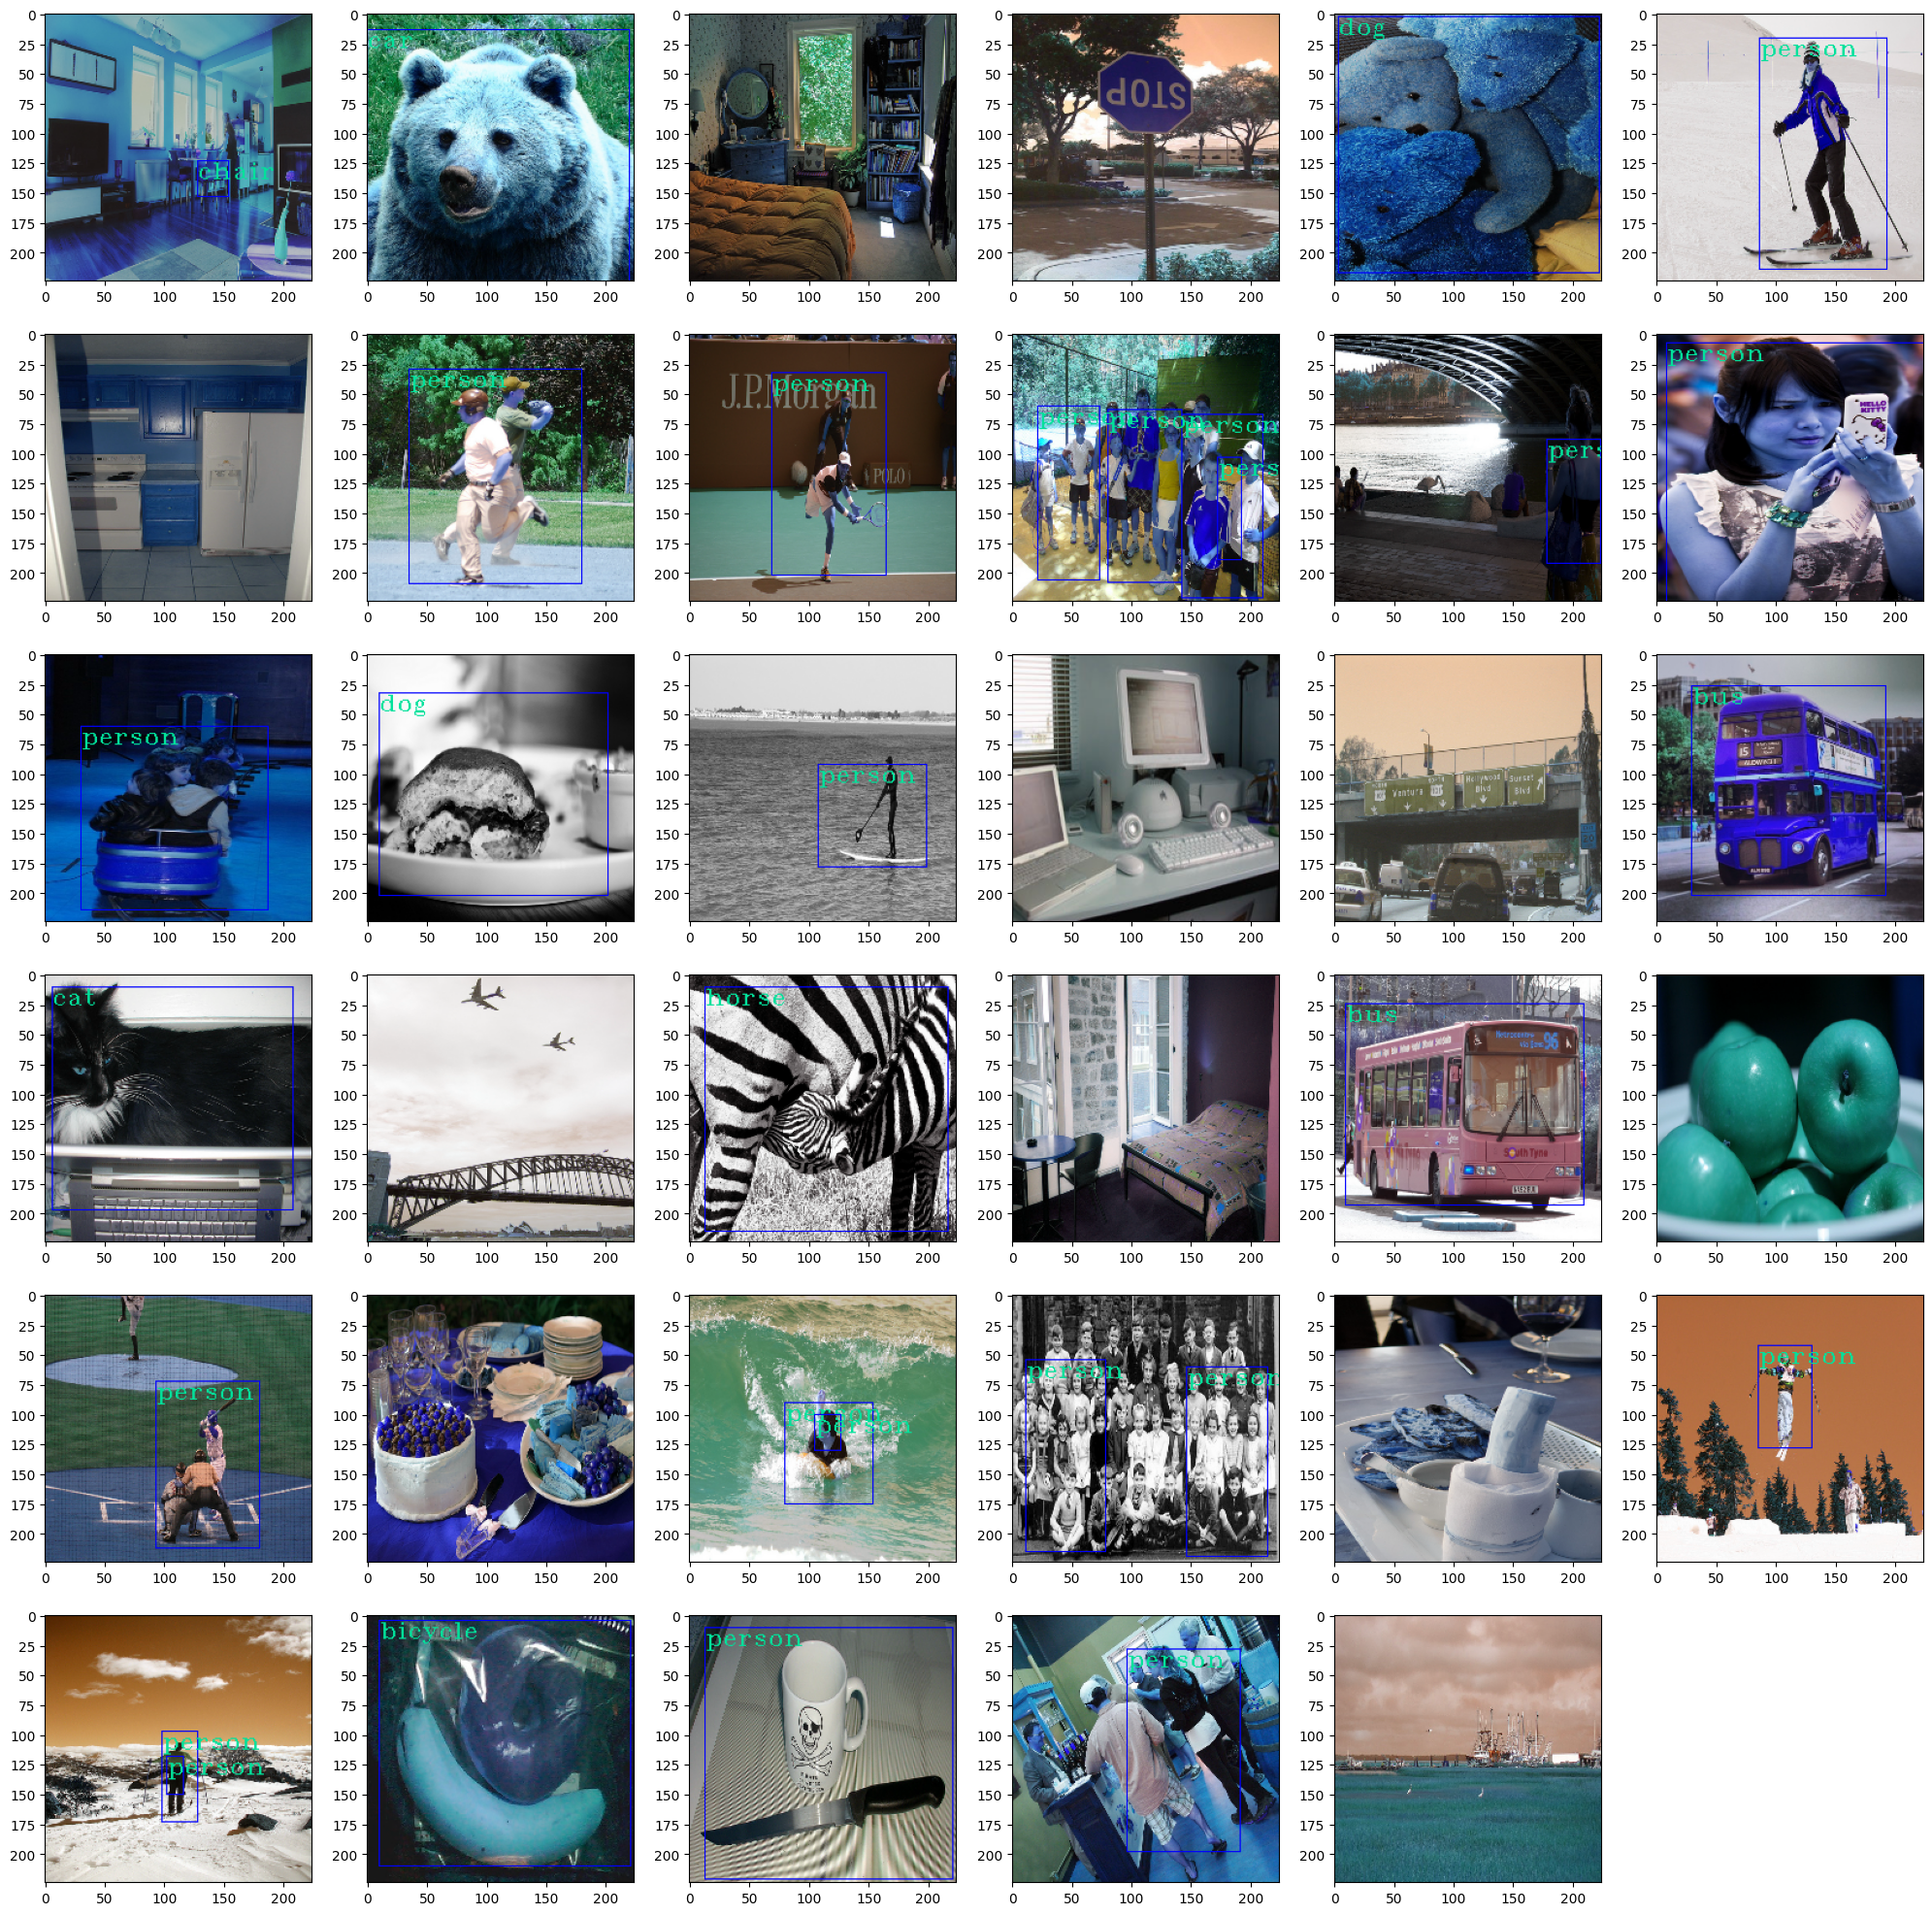

In [66]:
count = 1
plt.figure(figsize= (25, 25))
for filename in os.listdir(COCO_PATH):
    res = model_test(filename)
    plt.subplot(6,6,count)
    plt.imshow(res)
    count += 1
    if count >= 36:
        break
   